<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/cnn2_50epoch_flower_D_c_G_c_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#パッケージのダウンロード


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import argparse

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torchvision.transforms as transforms

In [ ]:
import torchvision.datasets as dset

In [ ]:
import torchvision.utils as vutils

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [ ]:
import glob

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

In [ ]:
from torch.utils.data import DataLoader
import torchvision

In [ ]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 12.0 MB/s eta 0:00:00


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 262MB/s]


In [ ]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [ ]:
#ハイパーパラメータの設定

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=128)
parser.add_argument("--nch_d", type = int, default=128)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=128, nch_d=128, z_dim=100, beta1=0.5)


In [ ]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [ ]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [ ]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [ ]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [ ]:
#モデルの設定

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [ ]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [ ]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [ ]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [ ]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [ ]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [ ]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [ ]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [ ]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [ ]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=False, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [ ]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)

        out = self.conv3(out)

        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [ ]:
#モデルのトレーニング

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
device

device(type='cuda')

In [ ]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt4): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slo

In [ ]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [01:29<00:00,  1.15it/s]


epoch: 0, lossD:3.268672817829743, lossG:21.568687226008443,lossG_fake:15.342066686130265, lossG_real:6.226620528883147 ,equality:9.115446157247117


evaluate:83.65374755859375,kid_mean:0.03313494101166725, kid_std:0.011007384397089481,kid_:(tensor(0.0331), tensor(0.0110))


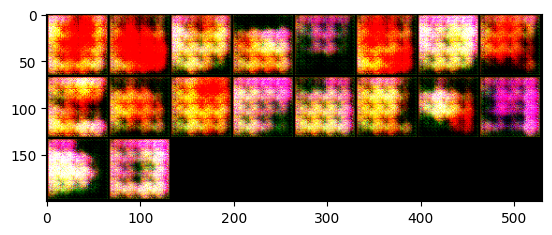

100%|██████████| 103/103 [00:19<00:00,  5.19it/s]


epoch: 1, lossD:1.7276571514537034, lossG:7.389924466031269,lossG_fake:4.325049322785683, lossG_real:3.0648751279104105 ,equality:1.260174194875273


evaluate:93.5796890258789,kid_mean:0.04498304799199104, kid_std:0.02389802783727646,kid_:(tensor(0.0450), tensor(0.0239))


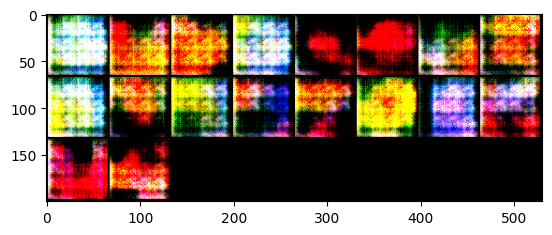

100%|██████████| 103/103 [00:20<00:00,  5.02it/s]


epoch: 2, lossD:1.6112136782951725, lossG:7.108815966300594,lossG_fake:4.190827160784342, lossG_real:2.9179888098563964 ,equality:1.2728383509279455


evaluate:94.35587310791016,kid_mean:0.052406858652830124, kid_std:0.02701309323310852,kid_:(tensor(0.0524), tensor(0.0270))


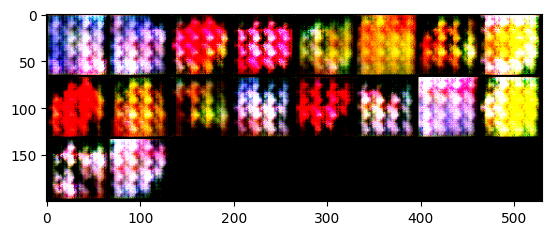

100%|██████████| 103/103 [00:21<00:00,  4.85it/s]


epoch: 3, lossD:1.7249865757608878, lossG:5.8315575701519125,lossG_fake:3.4091088418821687, lossG_real:2.4224487239295995 ,equality:0.9866601179525691


evaluate:87.057373046875,kid_mean:0.04673174023628235, kid_std:0.02300822176039219,kid_:(tensor(0.0467), tensor(0.0230))


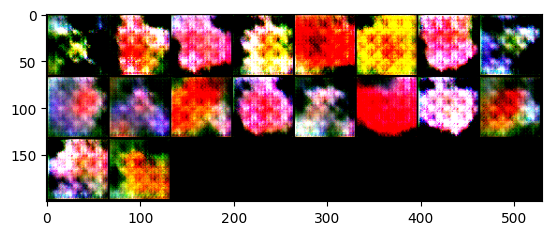

100%|██████████| 103/103 [00:21<00:00,  4.74it/s]


epoch: 4, lossD:1.6472111026060234, lossG:5.7919702205843135,lossG_fake:3.4390755370982644, lossG_real:2.3528946559984707 ,equality:1.0861808810997937


evaluate:90.8700180053711,kid_mean:0.0589749813079834, kid_std:0.03268399089574814,kid_:(tensor(0.0590), tensor(0.0327))


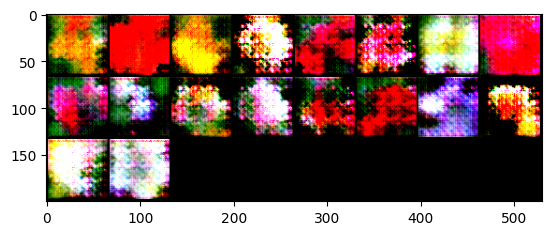

100%|██████████| 103/103 [00:21<00:00,  4.85it/s]


epoch: 5, lossD:1.49352282748639, lossG:5.742385091133488,lossG_fake:3.38895875273399, lossG_real:2.3534263320339535 ,equality:1.0355324207000365


evaluate:91.97884368896484,kid_mean:0.06121669337153435, kid_std:0.031266484409570694,kid_:(tensor(0.0612), tensor(0.0313))


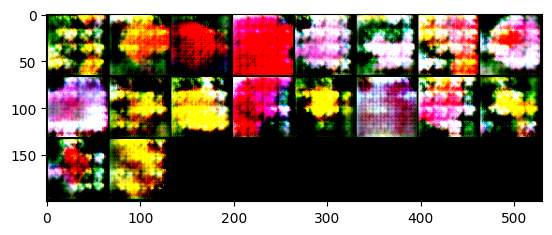

100%|██████████| 103/103 [00:21<00:00,  4.80it/s]


epoch: 6, lossD:1.4725101335534772, lossG:5.908937315339023,lossG_fake:3.47420226601721, lossG_real:2.4347350258850358 ,equality:1.0394672401321743


evaluate:85.27924346923828,kid_mean:0.05887140333652496, kid_std:0.033081505447626114,kid_:(tensor(0.0589), tensor(0.0331))


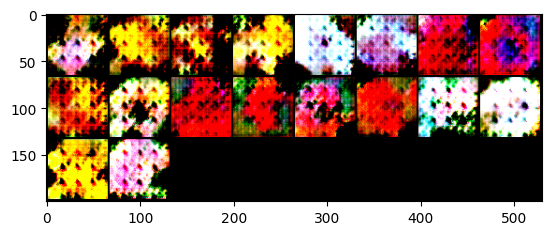

100%|██████████| 103/103 [00:21<00:00,  4.83it/s]


epoch: 7, lossD:1.341378579440626, lossG:6.090095871860541,lossG_fake:3.5939580364134707, lossG_real:2.496137847310131 ,equality:1.0978201891033397


evaluate:80.876220703125,kid_mean:0.05517895519733429, kid_std:0.029043586924672127,kid_:(tensor(0.0552), tensor(0.0290))


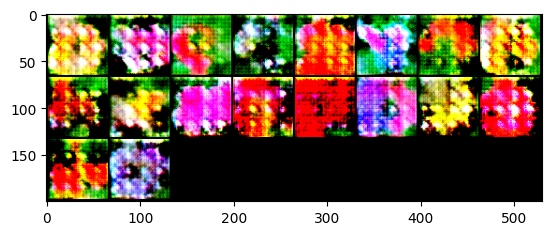

100%|██████████| 103/103 [00:21<00:00,  4.83it/s]


epoch: 8, lossD:1.3348593318346635, lossG:6.147057287901351,lossG_fake:3.593006102784166, lossG_real:2.554051191482729 ,equality:1.038954911301437


evaluate:76.71821594238281,kid_mean:0.04747532680630684, kid_std:0.033507004380226135,kid_:(tensor(0.0475), tensor(0.0335))


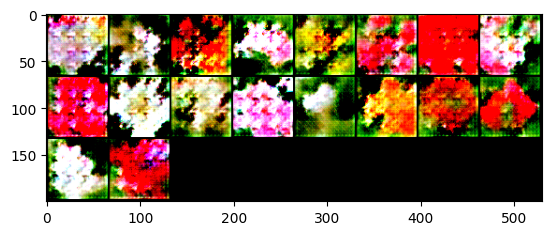

100%|██████████| 103/103 [00:21<00:00,  4.80it/s]


epoch: 9, lossD:1.364981355597672, lossG:5.863807854143161,lossG_fake:3.4289290962867365, lossG_real:2.4348787572777386 ,equality:0.9940503390089979


evaluate:80.27999114990234,kid_mean:0.05190756171941757, kid_std:0.03356862813234329,kid_:(tensor(0.0519), tensor(0.0336))


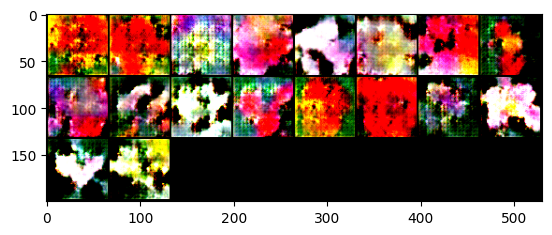

100%|██████████| 103/103 [00:21<00:00,  4.83it/s]


epoch: 10, lossD:1.459711613006962, lossG:5.776084552690821,lossG_fake:3.4119472017565977, lossG_real:2.364137372924286 ,equality:1.0478098288323117


evaluate:80.86959075927734,kid_mean:0.05815281718969345, kid_std:0.033175356686115265,kid_:(tensor(0.0582), tensor(0.0332))


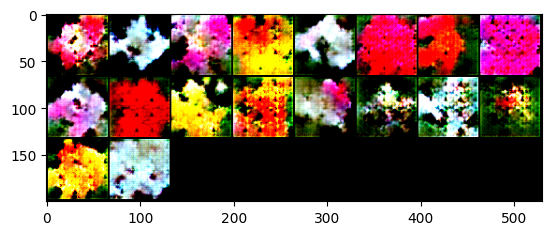

100%|██████████| 103/103 [00:21<00:00,  4.82it/s]


epoch: 11, lossD:1.4083433290129725, lossG:5.863103741581,lossG_fake:3.3570801980287124, lossG_real:2.5060235574407486 ,equality:0.8510566405879638


evaluate:86.66233825683594,kid_mean:0.05190183222293854, kid_std:0.031756170094013214,kid_:(tensor(0.0519), tensor(0.0318))


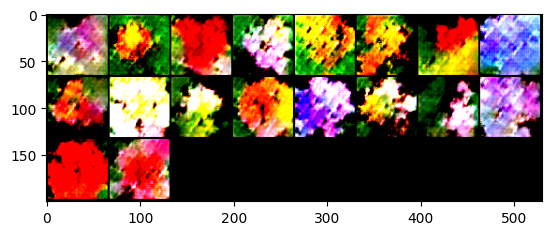

100%|██████████| 103/103 [00:21<00:00,  4.81it/s]


epoch: 12, lossD:1.3898578662316776, lossG:5.810233046707598,lossG_fake:3.3388491799530473, lossG_real:2.4713838574955767 ,equality:0.8674653224574707


evaluate:87.60730743408203,kid_mean:0.061396416276693344, kid_std:0.03610486537218094,kid_:(tensor(0.0614), tensor(0.0361))


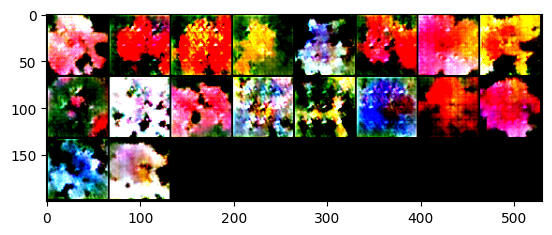

100%|██████████| 103/103 [00:21<00:00,  4.81it/s]


epoch: 13, lossD:1.2790012041341912, lossG:6.1932075370862645,lossG_fake:3.5826138396864957, lossG_real:2.6105936887194807 ,equality:0.972020150967015


evaluate:87.7668685913086,kid_mean:0.06480153650045395, kid_std:0.03689457103610039,kid_:(tensor(0.0648), tensor(0.0369))


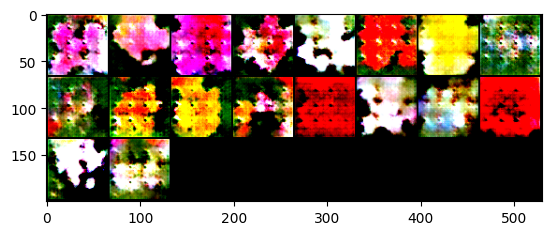

100%|██████████| 103/103 [00:21<00:00,  4.81it/s]


epoch: 14, lossD:1.2822372253658703, lossG:6.287107782456482,lossG_fake:3.645706652437599, lossG_real:2.6414011204705656 ,equality:1.0043055319670335


evaluate:86.88359069824219,kid_mean:0.06578625738620758, kid_std:0.03731989488005638,kid_:(tensor(0.0658), tensor(0.0373))


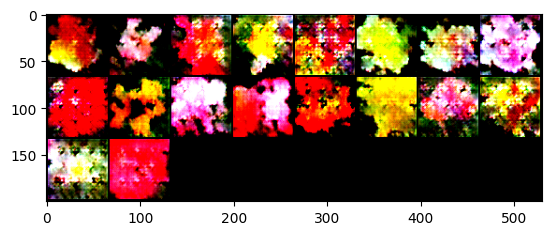

100%|██████████| 103/103 [00:21<00:00,  4.81it/s]


epoch: 15, lossD:1.1758475465681946, lossG:6.3692515660258175,lossG_fake:3.6644622162707803, lossG_real:2.704789364222184 ,equality:0.9596728520485964


evaluate:86.7954330444336,kid_mean:0.06510291248559952, kid_std:0.045459114015102386,kid_:(tensor(0.0651), tensor(0.0455))


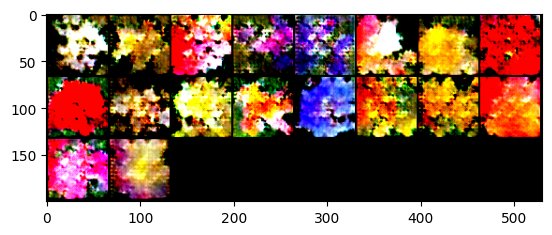

100%|██████████| 103/103 [00:21<00:00,  4.81it/s]


epoch: 16, lossD:1.1988207006338731, lossG:6.519344649268586,lossG_fake:3.6703122460726396, lossG_real:2.849032430394182 ,equality:0.8212798156784578


evaluate:86.19481658935547,kid_mean:0.06452587991952896, kid_std:0.03429359197616577,kid_:(tensor(0.0645), tensor(0.0343))


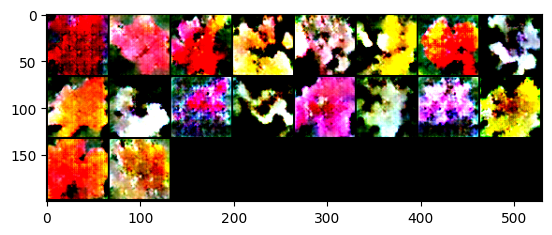

100%|██████████| 103/103 [00:21<00:00,  4.82it/s]


epoch: 17, lossD:1.2079906304484431, lossG:6.537825269606507,lossG_fake:3.6927015191143, lossG_real:2.845123761197896 ,equality:0.8475777579164041


evaluate:89.53939056396484,kid_mean:0.06650330126285553, kid_std:0.041494645178318024,kid_:(tensor(0.0665), tensor(0.0415))


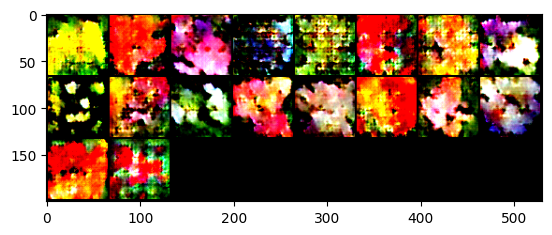

100%|██████████| 103/103 [00:21<00:00,  4.81it/s]


epoch: 18, lossD:1.1796877361038356, lossG:6.557503538224304,lossG_fake:3.723782119531076, lossG_real:2.833721427373516 ,equality:0.8900606921575602


evaluate:89.8187255859375,kid_mean:0.0663231760263443, kid_std:0.03715846315026283,kid_:(tensor(0.0663), tensor(0.0372))


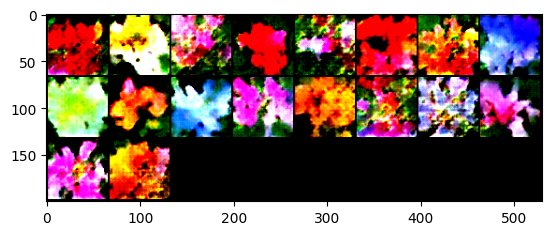

100%|██████████| 103/103 [00:21<00:00,  4.83it/s]


epoch: 19, lossD:1.1835893082965925, lossG:6.449496343297866,lossG_fake:3.6004118074491185, lossG_real:2.8490845650723835 ,equality:0.751327242376735


evaluate:88.85140991210938,kid_mean:0.0662202462553978, kid_std:0.038826555013656616,kid_:(tensor(0.0662), tensor(0.0388))


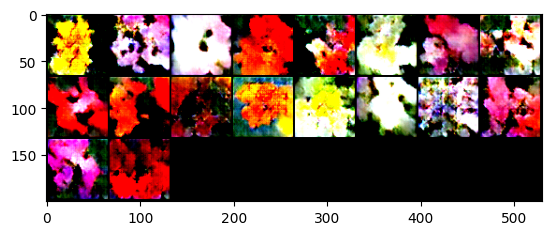

100%|██████████| 103/103 [00:21<00:00,  4.82it/s]


epoch: 20, lossD:1.1350300624532608, lossG:6.565866016647191,lossG_fake:3.645126023917522, lossG_real:2.9207400054607575 ,equality:0.7243860184567645


evaluate:86.2247085571289,kid_mean:0.06640215218067169, kid_std:0.03179706260561943,kid_:(tensor(0.0664), tensor(0.0318))


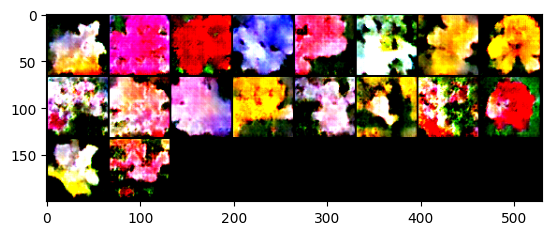

100%|██████████| 103/103 [00:21<00:00,  4.82it/s]


epoch: 21, lossD:1.0549381161199032, lossG:6.821672022921367,lossG_fake:3.853919059327505, lossG_real:2.9677529821118105 ,equality:0.8861660772156945


evaluate:84.10243225097656,kid_mean:0.06315122544765472, kid_std:0.03543403744697571,kid_:(tensor(0.0632), tensor(0.0354))


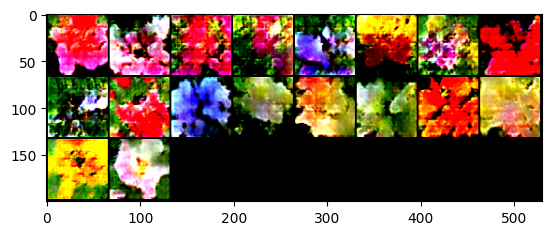

100%|██████████| 103/103 [00:21<00:00,  4.81it/s]


epoch: 22, lossD:1.214245053170954, lossG:6.557541731491829,lossG_fake:3.716707404956077, lossG_real:2.8408343363734123 ,equality:0.8758730685826648


evaluate:86.34001922607422,kid_mean:0.05919995158910751, kid_std:0.03542983531951904,kid_:(tensor(0.0592), tensor(0.0354))


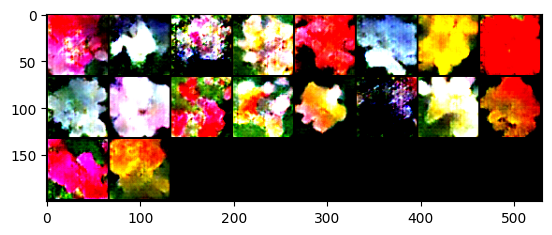

100%|██████████| 103/103 [00:21<00:00,  4.84it/s]


epoch: 23, lossD:1.0240381226956266, lossG:6.786806277858401,lossG_fake:3.778217276323189, lossG_real:3.008588995169667 ,equality:0.7696282811535218


evaluate:87.89077758789062,kid_mean:0.06706226617097855, kid_std:0.03967791050672531,kid_:(tensor(0.0671), tensor(0.0397))


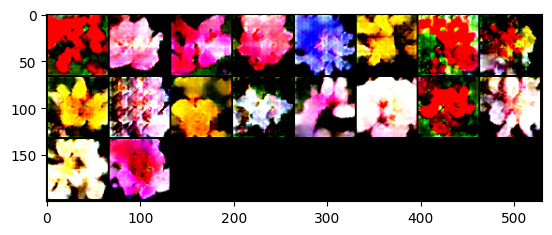

100%|██████████| 103/103 [00:21<00:00,  4.82it/s]


epoch: 24, lossD:1.0278737730192906, lossG:6.802011063955362,lossG_fake:3.802418634729478, lossG_real:2.9995924251750834 ,equality:0.8028262095543948


evaluate:88.88062286376953,kid_mean:0.06973419338464737, kid_std:0.04300384595990181,kid_:(tensor(0.0697), tensor(0.0430))


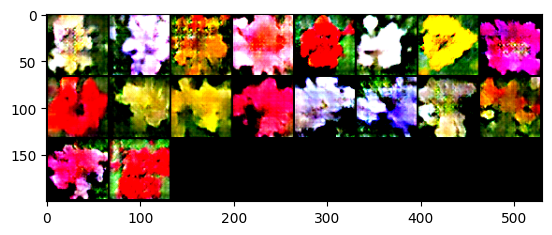

100%|██████████| 103/103 [00:21<00:00,  4.82it/s]


epoch: 25, lossD:1.0486748062291191, lossG:6.997798623390568,lossG_fake:3.9006558569889624, lossG_real:3.0971427635081765 ,equality:0.8035130934807859


evaluate:89.12918090820312,kid_mean:0.06355559825897217, kid_std:0.03950580582022667,kid_:(tensor(0.0636), tensor(0.0395))


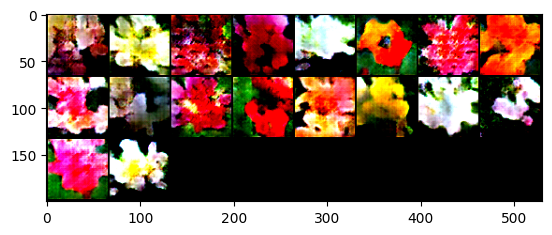

100%|██████████| 103/103 [00:21<00:00,  4.81it/s]


epoch: 26, lossD:0.9837767334238997, lossG:6.966515318861285,lossG_fake:3.9468694392917225, lossG_real:3.019645882462992 ,equality:0.9272235568287304


evaluate:91.5521469116211,kid_mean:0.06667793542146683, kid_std:0.03909842669963837,kid_:(tensor(0.0667), tensor(0.0391))


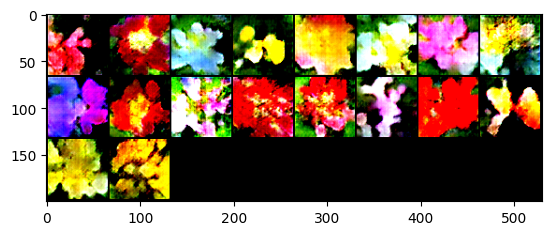

100%|██████████| 103/103 [00:21<00:00,  4.81it/s]


epoch: 27, lossD:0.9651651628387784, lossG:7.0964614071892305,lossG_fake:4.011213703062928, lossG_real:3.08524770586236 ,equality:0.9259659972005676


evaluate:90.3585433959961,kid_mean:0.06273818761110306, kid_std:0.03765597566962242,kid_:(tensor(0.0627), tensor(0.0377))


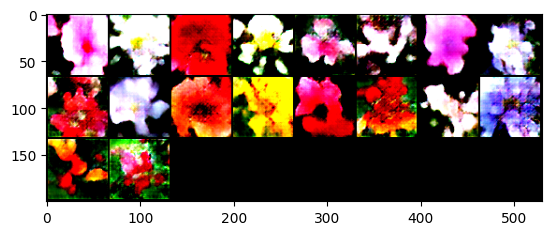

100%|██████████| 103/103 [00:21<00:00,  4.82it/s]


epoch: 28, lossD:1.0457625811539808, lossG:6.9836089356431685,lossG_fake:3.9141726869981266, lossG_real:3.0694362411221254 ,equality:0.8447364458760012


evaluate:90.37163543701172,kid_mean:0.06285705417394638, kid_std:0.036564528942108154,kid_:(tensor(0.0629), tensor(0.0366))


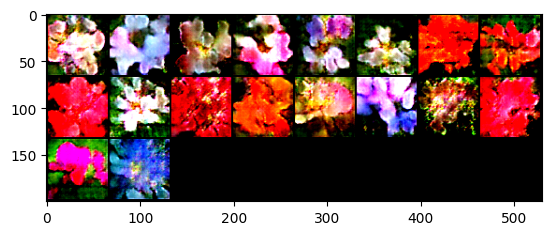

100%|██████████| 103/103 [00:21<00:00,  4.83it/s]


epoch: 29, lossD:1.0942880566259032, lossG:6.999312118419166,lossG_fake:3.909139969973888, lossG_real:3.09017214670922 ,equality:0.8189678232646682


evaluate:91.53433227539062,kid_mean:0.0667881891131401, kid_std:0.030284442007541656,kid_:(tensor(0.0668), tensor(0.0303))


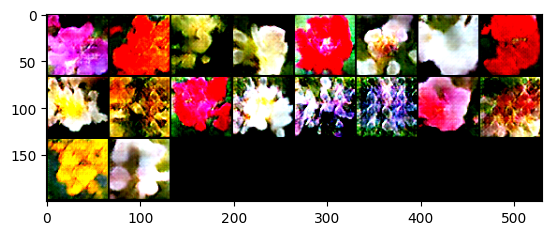

100%|██████████| 103/103 [00:21<00:00,  4.81it/s]


epoch: 30, lossD:0.9882044615676102, lossG:7.026023003661517,lossG_fake:3.8741874810561394, lossG_real:3.151835515661147 ,equality:0.7223519653949926


evaluate:90.52307891845703,kid_mean:0.07298390567302704, kid_std:0.0413956344127655,kid_:(tensor(0.0730), tensor(0.0414))


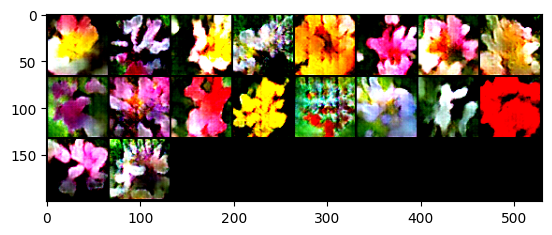

100%|██████████| 103/103 [00:21<00:00,  4.80it/s]


epoch: 31, lossD:0.9346520382802463, lossG:7.3352296421828775,lossG_fake:4.153988045396157, lossG_real:3.181241579136802 ,equality:0.972746466259355


evaluate:92.56570434570312,kid_mean:0.06513005495071411, kid_std:0.04085613787174225,kid_:(tensor(0.0651), tensor(0.0409))


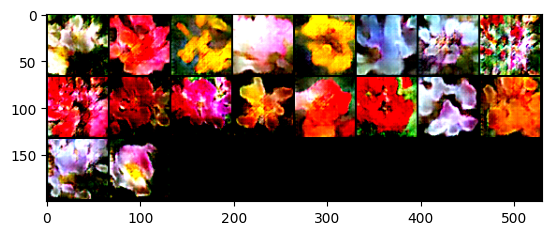

100%|██████████| 103/103 [00:21<00:00,  4.83it/s]


epoch: 32, lossD:0.8410579667797367, lossG:7.5437679383361225,lossG_fake:4.216197880726416, lossG_real:3.3275700442999314 ,equality:0.888627836426485


evaluate:92.26809692382812,kid_mean:0.06072408705949783, kid_std:0.03721103072166443,kid_:(tensor(0.0607), tensor(0.0372))


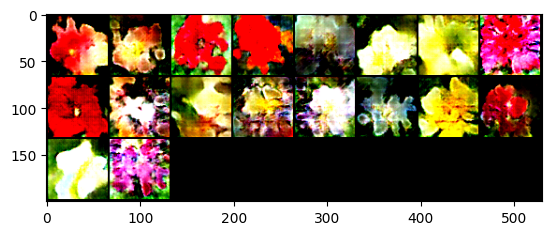

100%|██████████| 103/103 [00:21<00:00,  4.81it/s]


epoch: 33, lossD:0.9873365829291852, lossG:7.35750912231149,lossG_fake:4.136593684409428, lossG_real:3.2209153962366788 ,equality:0.9156782881727494


evaluate:91.8345718383789,kid_mean:0.05672074481844902, kid_std:0.03223465010523796,kid_:(tensor(0.0567), tensor(0.0322))


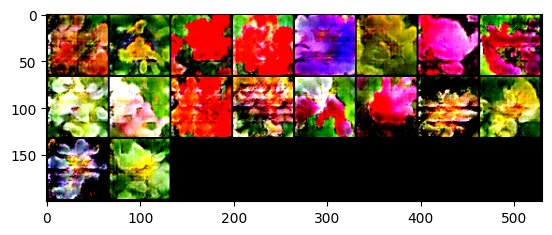

100%|██████████| 103/103 [00:21<00:00,  4.81it/s]


epoch: 34, lossD:0.8317172498378939, lossG:7.407173925233119,lossG_fake:4.13757751751872, lossG_real:3.2695963984554255 ,equality:0.8679811190632942


evaluate:92.52557373046875,kid_mean:0.06048959866166115, kid_std:0.036007095128297806,kid_:(tensor(0.0605), tensor(0.0360))


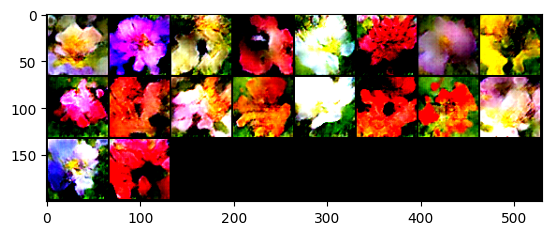

100%|██████████| 103/103 [00:21<00:00,  4.83it/s]


epoch: 35, lossD:0.9689540570800744, lossG:7.46965070835595,lossG_fake:4.222763237443942, lossG_real:3.246887441977714 ,equality:0.9758757954662283


evaluate:91.46820068359375,kid_mean:0.06047751381993294, kid_std:0.03546222299337387,kid_:(tensor(0.0605), tensor(0.0355))


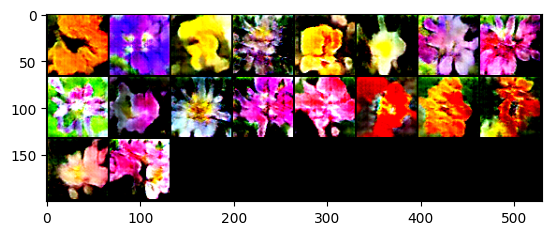

100%|██████████| 103/103 [00:21<00:00,  4.82it/s]


epoch: 36, lossD:0.9265623007295201, lossG:7.283179597947204,lossG_fake:4.035543870000006, lossG_real:3.2476357262111404 ,equality:0.7879081437888655


evaluate:91.21478271484375,kid_mean:0.06658247113227844, kid_std:0.041347138583660126,kid_:(tensor(0.0666), tensor(0.0413))


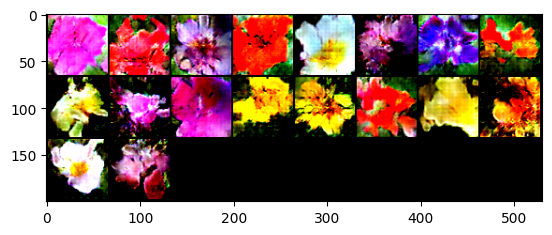

100%|██████████| 103/103 [00:21<00:00,  4.80it/s]


epoch: 37, lossD:0.8545606184063606, lossG:7.568650051228051,lossG_fake:4.206803539424267, lossG_real:3.361846499072695 ,equality:0.8449570403515718


evaluate:91.21282958984375,kid_mean:0.06171648949384689, kid_std:0.03764898702502251,kid_:(tensor(0.0617), tensor(0.0376))


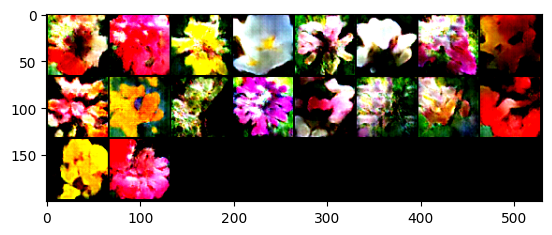

100%|██████████| 103/103 [00:21<00:00,  4.79it/s]


epoch: 38, lossD:0.9491289204474792, lossG:7.435818926801959,lossG_fake:4.139800514411, lossG_real:3.2960184094975298 ,equality:0.8437821049134704


evaluate:91.36409759521484,kid_mean:0.06498468667268753, kid_std:0.03807242959737778,kid_:(tensor(0.0650), tensor(0.0381))


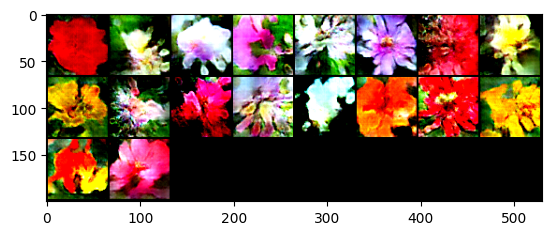

100%|██████████| 103/103 [00:21<00:00,  4.83it/s]


epoch: 39, lossD:0.7879766112971074, lossG:7.566852412177521,lossG_fake:4.170751345967783, lossG_real:3.396101077204769 ,equality:0.7746502687630143


evaluate:92.3458251953125,kid_mean:0.06013666093349457, kid_std:0.03410138934850693,kid_:(tensor(0.0601), tensor(0.0341))


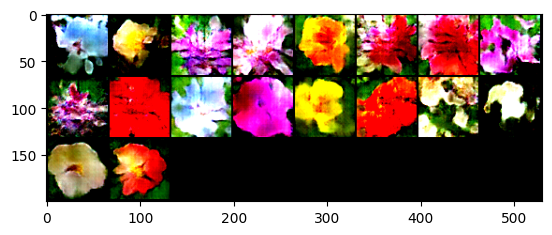

100%|██████████| 103/103 [00:21<00:00,  4.82it/s]


epoch: 40, lossD:0.9473200104768994, lossG:7.395016980402678,lossG_fake:4.050694744563797, lossG_real:3.34432223178808 ,equality:0.7063725127757174


evaluate:93.522216796875,kid_mean:0.058725930750370026, kid_std:0.02766132727265358,kid_:(tensor(0.0587), tensor(0.0277))


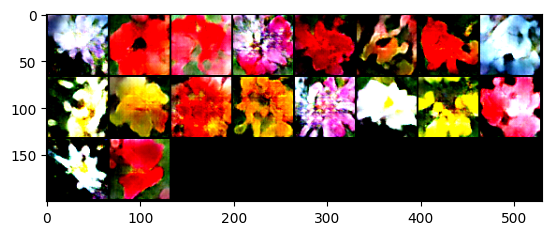

100%|██████████| 103/103 [00:21<00:00,  4.81it/s]


epoch: 41, lossD:0.8846219264477202, lossG:7.232305938757739,lossG_fake:3.8722793543801726, lossG_real:3.3600265939258835 ,equality:0.512252760454289


evaluate:93.46074676513672,kid_mean:0.06527135521173477, kid_std:0.031756266951560974,kid_:(tensor(0.0653), tensor(0.0318))


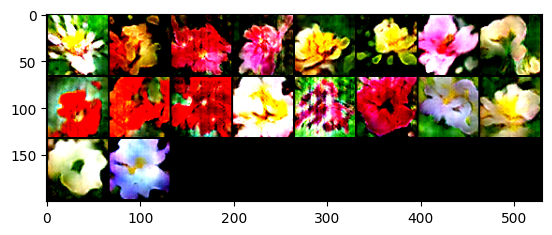

100%|██████████| 103/103 [00:21<00:00,  4.76it/s]


epoch: 42, lossD:0.8394191674526456, lossG:7.471226118143322,lossG_fake:4.049977211118902, lossG_real:3.4212489076031063 ,equality:0.6287283035157958


evaluate:95.28440856933594,kid_mean:0.061824437230825424, kid_std:0.03595418110489845,kid_:(tensor(0.0618), tensor(0.0360))


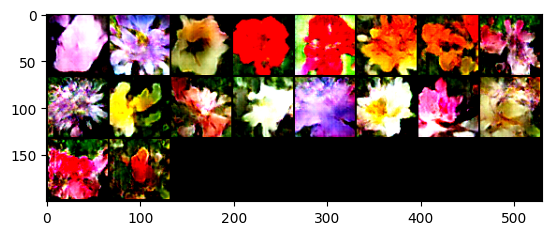

100%|██████████| 103/103 [00:21<00:00,  4.84it/s]


epoch: 43, lossD:0.8093480177006676, lossG:7.752008965871866,lossG_fake:4.256168039099684, lossG_real:3.4958409261934964 ,equality:0.7603271129061877


evaluate:96.18598175048828,kid_mean:0.0700976699590683, kid_std:0.036454569548368454,kid_:(tensor(0.0701), tensor(0.0365))


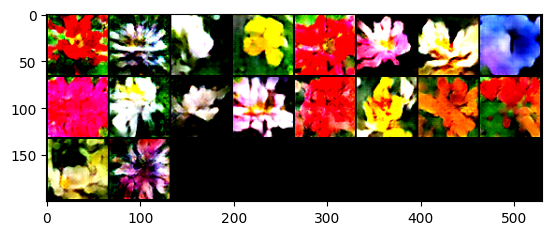

100%|██████████| 103/103 [00:21<00:00,  4.89it/s]


epoch: 44, lossD:0.7300399833367867, lossG:7.799589032108344,lossG_fake:4.221402884687035, lossG_real:3.578186108649356 ,equality:0.6432167760376792


evaluate:98.12853240966797,kid_mean:0.06518595665693283, kid_std:0.0367642417550087,kid_:(tensor(0.0652), tensor(0.0368))


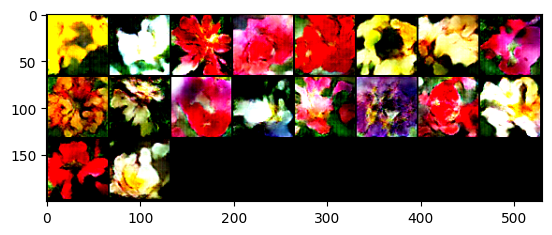

100%|██████████| 103/103 [00:20<00:00,  4.94it/s]


epoch: 45, lossD:0.8490527421959395, lossG:7.639473711402671,lossG_fake:4.160842883355409, lossG_real:3.4786308297833193 ,equality:0.6822120535720897


evaluate:98.10391235351562,kid_mean:0.0658479854464531, kid_std:0.043003447353839874,kid_:(tensor(0.0658), tensor(0.0430))


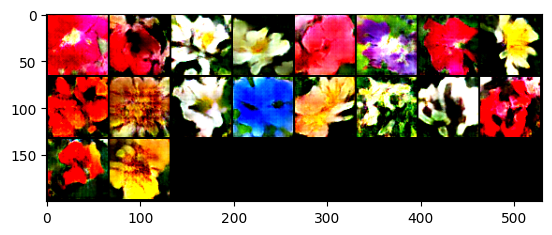

100%|██████████| 103/103 [00:20<00:00,  4.95it/s]


epoch: 46, lossD:0.8358663133915188, lossG:7.754701887519614,lossG_fake:4.206784922521091, lossG_real:3.5479169621050937 ,equality:0.6588679604159977


evaluate:99.097412109375,kid_mean:0.06846915185451508, kid_std:0.0436105839908123,kid_:(tensor(0.0685), tensor(0.0436))


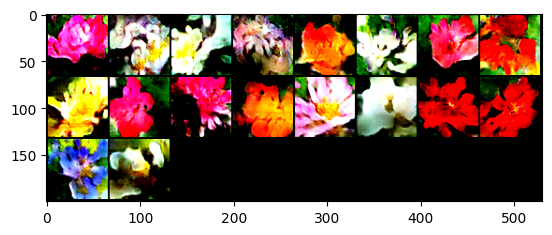

100%|██████████| 103/103 [00:20<00:00,  4.99it/s]


epoch: 47, lossD:0.662784288375123, lossG:7.756169374706675,lossG_fake:4.222462560366658, lossG_real:3.5337068131826457 ,equality:0.6887557471840124


evaluate:99.38562774658203,kid_mean:0.07340528815984726, kid_std:0.03678671270608902,kid_:(tensor(0.0734), tensor(0.0368))


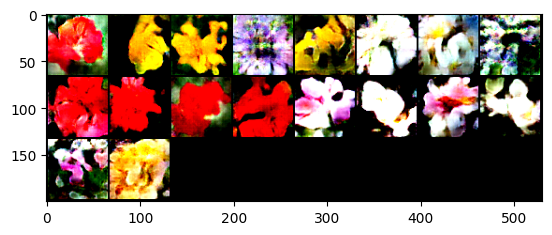

100%|██████████| 103/103 [00:20<00:00,  5.00it/s]


epoch: 48, lossD:0.716023997485059, lossG:7.732370654356132,lossG_fake:4.149563125036295, lossG_real:3.582807521218235 ,equality:0.5667556038180597


evaluate:99.22859191894531,kid_mean:0.06697607785463333, kid_std:0.03867172449827194,kid_:(tensor(0.0670), tensor(0.0387))


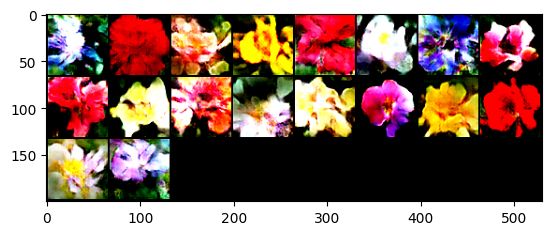

100%|██████████| 103/103 [00:20<00:00,  5.02it/s]


epoch: 49, lossD:0.8407612062484315, lossG:7.770629609672769,lossG_fake:4.214759333619794, lossG_real:3.555870257535027 ,equality:0.6588890760847668


evaluate:99.17996978759766,kid_mean:0.06771117448806763, kid_std:0.042916473001241684,kid_:(tensor(0.0677), tensor(0.0429))


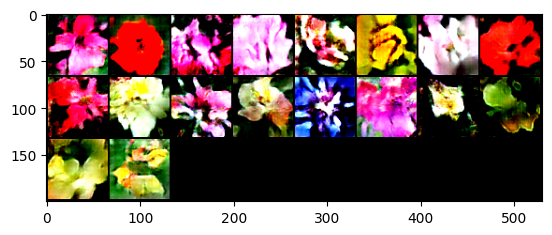

In [ ]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

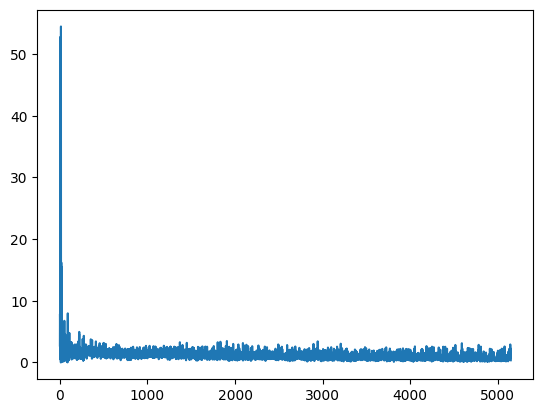

In [ ]:
plt.plot(raw_lossesD)

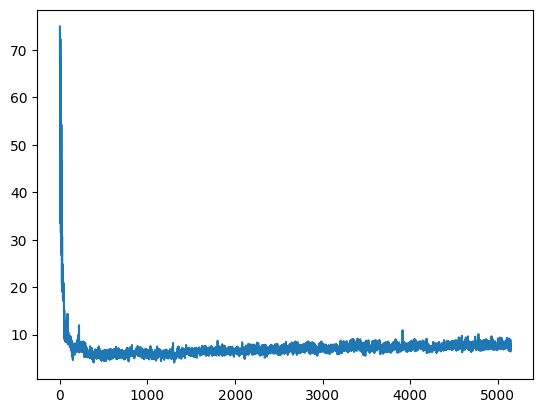

In [ ]:
plt.plot(raw_lossesG)

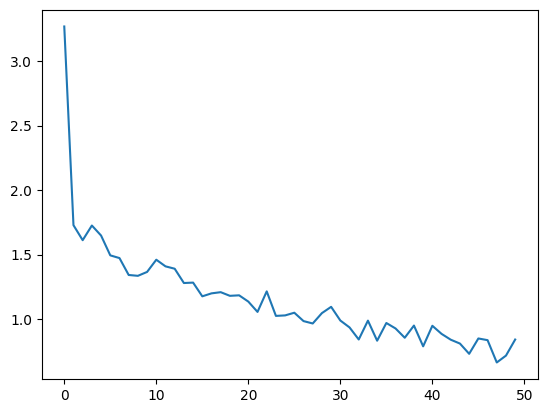

In [ ]:
plt.plot(lossesD)

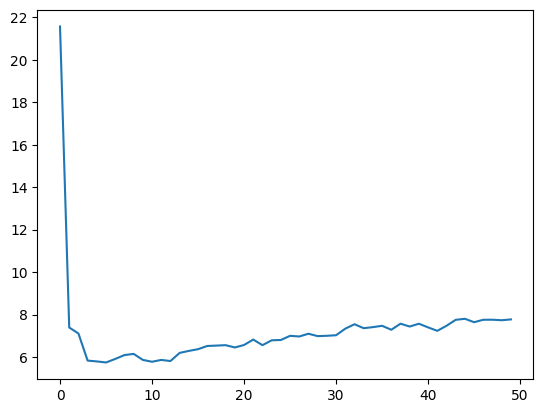

In [ ]:
plt.plot(lossesG)

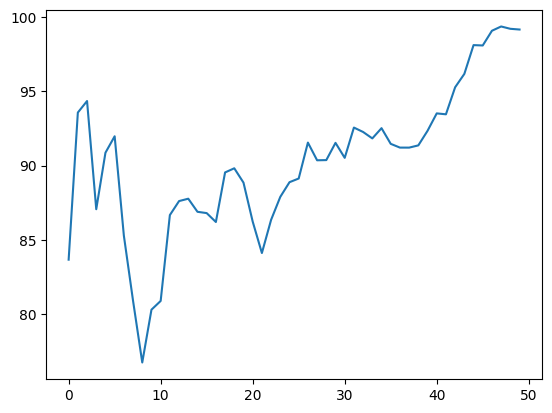

In [ ]:
plt.plot(fid_)

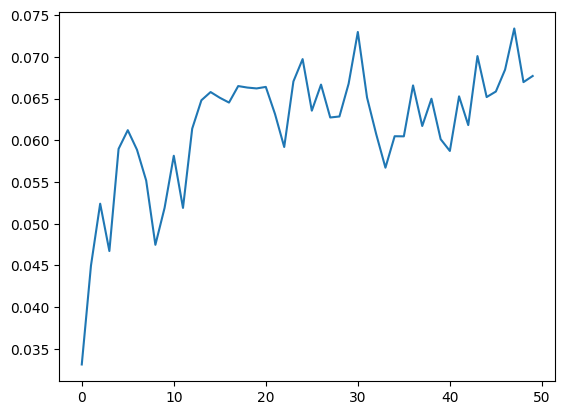

In [ ]:
plt.plot(kid_mean_)

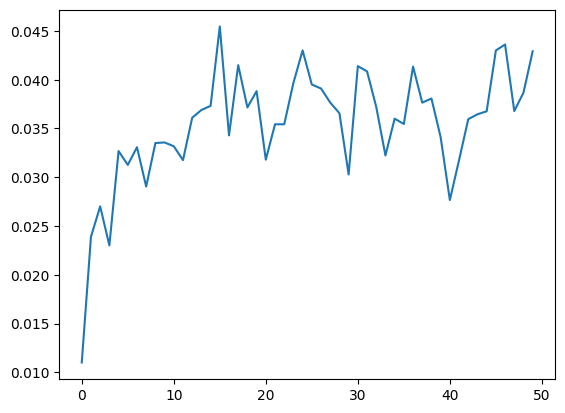

In [ ]:
plt.plot(kid_std_)

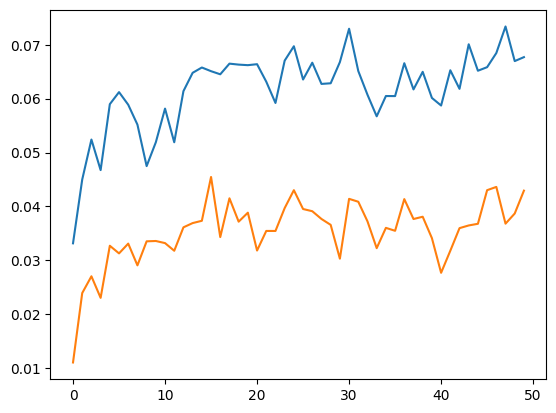

In [ ]:
plt.plot(kid_score)

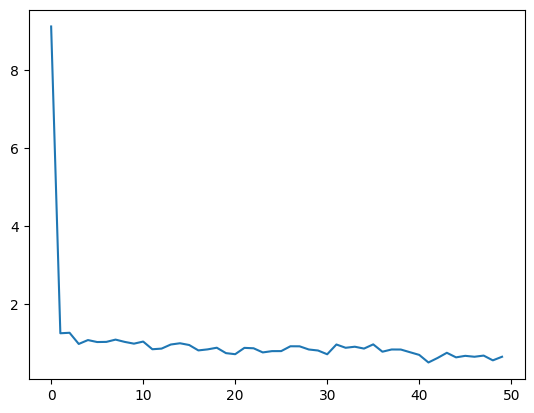

In [ ]:
plt.plot(d_equality)

In [ ]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0670), tensor(0.0434))